<a href="https://colab.research.google.com/github/ozlemakboyraz/Brain-Classification-Project/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms

# 1. GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!cp "/content/drive/MyDrive/brain-dataset/Dataset_224x224.rar" /content/
!unrar x /content/Dataset_224x224.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0713.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0714.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0715.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0716.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0717.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0718.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0719.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0720.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0721.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0722.jpg       26%  OK 
Extracting  /content/Dataset_224x

In [29]:
# 2. Veri Yolları ve Parametreler
DATA_DIR = '/content//Dataset_224x224' # Kendi yolunla güncelle
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PER_FOLD = 10  # Cross-validation uzun sürdüğü için makul bir sayı

In [30]:
# 3. Data Augmentation ve Normalizasyon
# MRI için Mean/Std (Genelde ImageNet değerleri transfer learning için tercih edilir)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [31]:
# 4. Model Oluşturma ve Katman Dondurma Fonksiyonu
def get_resnet_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # %40 Katman Dondurma Stratejisi
    # ResNet50'de layer1 ve öncesini dondurmak yaklaşık %35-40 dondurma sağlar
    for param in model.parameters():
        param.requires_grad = False

    # Layer 2, 3, 4 ve FC katmanlarını eğitime açıyoruz (%60 civarı)
    for param in model.layer2.parameters(): param.requires_grad = True
    for param in model.layer3.parameters(): param.requires_grad = True
    for param in model.layer4.parameters(): param.requires_grad = True

    # Çıkış katmanını 4 sınıf için güncelle
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model.fc.requires_grad = True

    return model.to(device)

In [32]:
# 5. Dataset Sınıfı (Augmentation kontrolü için)
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [33]:
# -----------------------------
# 6. 5-Fold Stratified Cross-Validation Eğitimi (ResNet50)
# -----------------------------
full_train_dataset = BrainMRIDataset(TRAIN_DIR)
labels = [sample[1] for sample in full_train_dataset.dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

final_history = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} BAŞLIYOR ---")

    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    train_sub.dataset.transform = train_transforms
    val_sub.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = get_resnet_model().to(device)

    optimizer = optim.Adam([
        {'params': model.layer2.parameters(), 'lr': 1e-5},
        {'params': model.layer3.parameters(), 'lr': 5e-5},
        {'params': model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.fc.parameters(), 'lr': 1e-3}
    ])

    criterion = nn.CrossEntropyLoss()

    fold_h = {'t_acc': [], 'v_acc': [], 't_loss': [], 'v_loss': []}

    for epoch in range(EPOCHS_PER_FOLD):
        # ---- Train ----
        model.train()
        t_loss, t_corr = 0.0, 0
        for inputs, labels_b in train_loader:
            inputs, labels_b = inputs.to(device), labels_b.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_b)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            t_loss += loss.item() * inputs.size(0)
            t_corr += torch.sum(preds == labels_b.data)

        # ---- Validation ----
        model.eval()
        v_loss, v_corr = 0.0, 0
        with torch.no_grad():
            for inputs, labels_b in val_loader:
                inputs, labels_b = inputs.to(device), labels_b.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_b)
                _, preds = torch.max(outputs, 1)
                v_loss += loss.item() * inputs.size(0)
                v_corr += torch.sum(preds == labels_b.data)

        # Epoch sonuçları
        train_epoch_loss = t_loss / len(train_idx)
        val_epoch_loss = v_loss / len(val_idx)
        fold_h['t_loss'].append(train_epoch_loss)
        fold_h['v_loss'].append(val_epoch_loss)
        fold_h['t_acc'].append((t_corr.double()/len(train_idx)).cpu().item())
        fold_h['v_acc'].append((v_corr.double()/len(val_idx)).cpu().item())

        print(f"Epoch {epoch+1}/{EPOCHS_PER_FOLD} | "
              f"Train Loss: {train_epoch_loss:.4f} Acc: {fold_h['t_acc'][-1]:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} Acc: {fold_h['v_acc'][-1]:.4f}")

    final_history.append(fold_h)


--- FOLD 1 BAŞLIYOR ---
Epoch 1/10 | Train Loss: 0.2642 Acc: 0.9048 | Val Loss: 0.0738 Acc: 0.9738
Epoch 2/10 | Train Loss: 0.0532 Acc: 0.9847 | Val Loss: 0.0444 Acc: 0.9843
Epoch 3/10 | Train Loss: 0.0281 Acc: 0.9904 | Val Loss: 0.0678 Acc: 0.9764
Epoch 4/10 | Train Loss: 0.0281 Acc: 0.9910 | Val Loss: 0.0880 Acc: 0.9711
Epoch 5/10 | Train Loss: 0.0179 Acc: 0.9943 | Val Loss: 0.0551 Acc: 0.9843
Epoch 6/10 | Train Loss: 0.0171 Acc: 0.9945 | Val Loss: 0.1042 Acc: 0.9746
Epoch 7/10 | Train Loss: 0.0183 Acc: 0.9934 | Val Loss: 0.1084 Acc: 0.9755
Epoch 8/10 | Train Loss: 0.0094 Acc: 0.9972 | Val Loss: 0.0569 Acc: 0.9816
Epoch 9/10 | Train Loss: 0.0073 Acc: 0.9974 | Val Loss: 0.0630 Acc: 0.9851
Epoch 10/10 | Train Loss: 0.0277 Acc: 0.9908 | Val Loss: 0.1353 Acc: 0.9641

--- FOLD 2 BAŞLIYOR ---
Epoch 1/10 | Train Loss: 0.2572 Acc: 0.9048 | Val Loss: 0.0994 Acc: 0.9650
Epoch 2/10 | Train Loss: 0.0507 Acc: 0.9842 | Val Loss: 0.0700 Acc: 0.9773
Epoch 3/10 | Train Loss: 0.0187 Acc: 0.9947 | Val

In [34]:
# 7. Test Seti Değerlendirmesi
# -----------------------------
print("\n--- TEST SETİ SONUÇLARI ---")
test_dataset = BrainMRIDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds, all_labels, all_probs = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels_b in test_loader:
        inputs, labels_b = inputs.to(device), labels_b.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_b.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metrikler
acc = accuracy_score(all_labels, all_preds)
p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Accuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")



--- TEST SETİ SONUÇLARI ---
Accuracy: 0.9809 | Precision: 0.9809 | Recall: 0.9809 | F1: 0.9809 | AUC: 0.9993


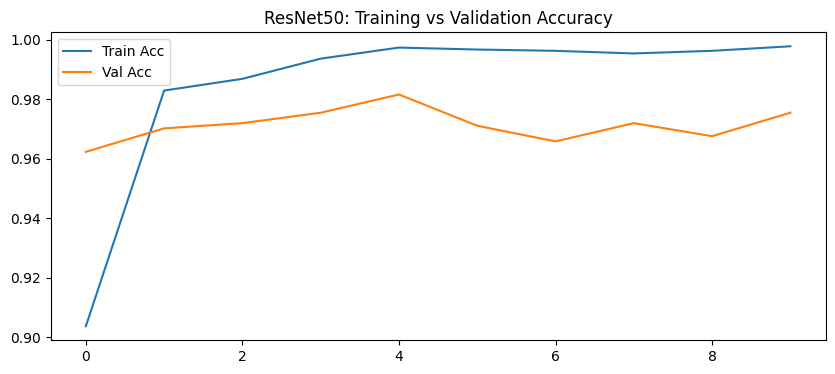

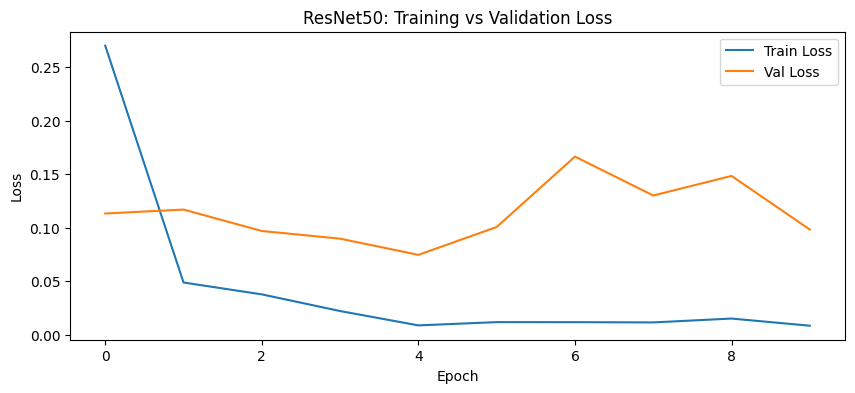

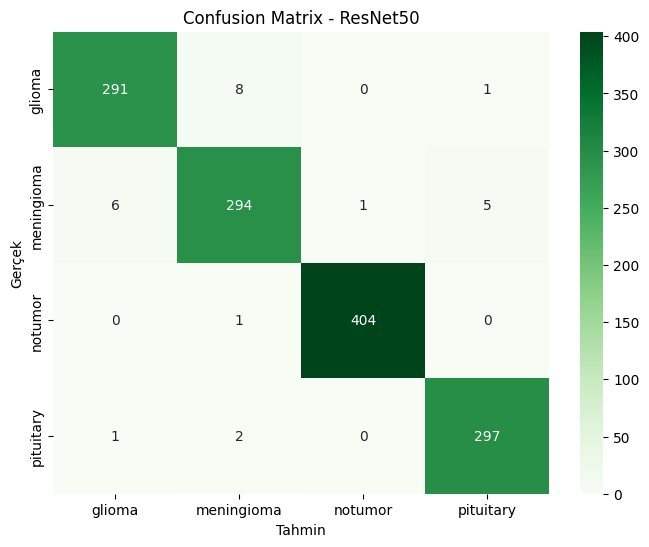

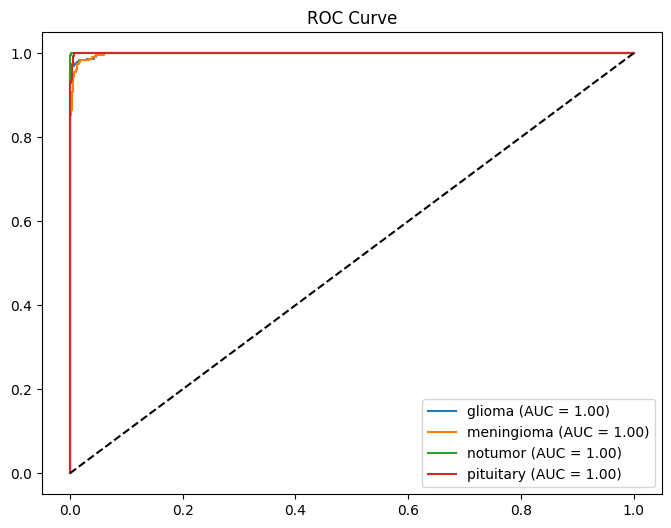

In [35]:
# 8. Grafikler
# -----------------------------
# Accuracy Grafiği
plt.figure(figsize=(10,4))
plt.plot(final_history[-1]['t_acc'], label='Train Acc')
plt.plot(final_history[-1]['v_acc'], label='Val Acc')
plt.title('ResNet50: Training vs Validation Accuracy')
plt.legend(); plt.show()

# Loss Grafiği
plt.figure(figsize=(10,4))
plt.plot(final_history[-1]['t_loss'], label='Train Loss')
plt.plot(final_history[-1]['v_loss'], label='Val Loss')
plt.title('ResNet50: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(); plt.show()

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix - ResNet50')
plt.ylabel('Gerçek'); plt.xlabel('Tahmin'); plt.show()

# ROC Eğrisi
plt.figure(figsize=(8,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f'{test_dataset.classes[i]} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--'); plt.title('ROC Curve'); plt.legend(); plt.show()